# Datathon: COVID-19 USA
## Importación de la base de datos.

Para importar la base de datos, se va a utilizar la biblioteca requests para solicitar los datos directamente a la página. De esta forma estandarizamos la adiquisición de los datos para que todos los usuarios puedan obtener los mismos resultados. 

Otra opción es descargar los datos directamente en formato JSON o CSV desde la página web del proyecto, y posteriormente importarlos en python empleando los métodos apropiados.

In [2]:
import pandas as pd
import requests

url = "https://api.covidtracking.com/v1/states/daily.json"

response = requests.get(url)

if response.status_code == 200:
    states_data = response.json()

    df = pd.DataFrame(states_data)

else:
    print(f"Error al solicitar los datos. Código {response.status_code}")


# Si queremos usar el archivo descargado utilizar pd.read_json o pd.read_csv en función del archivo descargado.


## Limpieza de la base de datos.

Una vez se han importado los datos, se debe decidir la forma en la que se va a comenzar la aproximación a la base. Dependiendo del trabajo de investigación que estemos realizando, o de lo que se nos haya solicitado en un entorno laboral, existen dos posibilidades:

- Trabajar con la totalidad de la base de datos y "pescar" resultados.
- Elegir una serie de variables de interés y extraer conclusiones.

Un detalle importante, que por el tipo de trabajo ante el que nos encontramos no estamos teniendo en cuenta, es que toda investigación tiene que ir apoyada sobre una base teórica. Cualquier investigación requiere que tengamos unos conceptos previos que lleven de la mano la investigación. Por ejemplo, en este proyecto de casos de COVID en EEUU, podríamos plantear una posible investigación que explore la hipótesis de que los estados con mayor número de vacunados son los estados que más ven reducida la mortalidad por COVID. Pero para hacer este proceso, necesitaríamos haber realizado previamente una revisión teórica que avale el sentido de esta hipótesis. La extensión de la misma depende mucho del entorno en el que nos estemos desarrollando, y en el caso de entornos laborales empresariales no encontraremos esta limitación a menudo, pero es tarea nuestra como expertos el aportar los buenos haceres en el trabajo.

Si bien es cierto que hoy en día con la expansión y mejora de los modelos de redes neuronales, machine learning, e IA en muchas ocasiones se plantean investigaciones en las que simplemente se buscan resultados "a peso". Es decir, se introducen todas las variables de las que disponemos y esperamos que se nos devuelva el mejor modelo posible. Hacer esto por supuesto es muy inoperante a nivel científico, ya que no disponer de una buena base teórica puede llevarnos a aceptar resultados totalmente incongruentes con la realidad, y a no tener en cuenta factores externos (variables de confusión, correlaciones espúreas, etc.) o posibles sesgos en la elaboración del modelo (¿son nuestros datos de calidad?). 

Otro punto importante a destacar es que, en investigación científica, trabajar con bases de datos preexistentes no siempre es lo más recomendado, ya que es una parte del proceso de investigación sobre el que perdemos el control, y no podemos determinar si se han llevado a cabo los controles suficientes y necesarios sobre la recogida de datos. Además, hay que tener en cuenta que no todo tipo de dato admite todo tipo de prueba estadística. Cuando se trabaja con modelos de machine learning nos encontraremos con casos en los que no se presta mucha atención a estas limitaciones, pero es importante considerar que tipo de dato disponemos en función de su recogida (transversal o longitudinal), en función de su tipología (binario, multinomial, continuo...) y en función del cumplimiento de supuestos en las variables relevantes.

Hecho este preámbulo, las consideraciones para limpiar la base de datos en este caso serán:
- Variables de interés (columnas que queremos quedarnos)
- Adecuación del formato (revisar que los datos sean congruentes con la variable)
- Análisis de datos perdidos (revisar el porcentaje de datos perdidos y considerar si merece la pena imputarlos)
- Análisis de valores atípicos (empleando la generalización de datos 1.5 desviaciones típicas por encima de Q3 o por debajo de Q1)

El primer paso por tanto será decidir que variables serán de interés. Al tratarse de una base de datos amplia, y para facilitar el trabajo, podemos hacer una exploración de datos generales que sean relevantes y analizar si existen algunas diferencias. Ya que disponemos de medidas en distintas fechas de muertes, hospitalizaciones, casos recuperados, tests positivos y negativos, podemos realizar una exploración de la evolución temporal por estado de cada una de estas variables. Además, podemos plantear realizar algún tipo de análisis para ver si existieron diferencias significativas entre el número de hospitalizaciones y muertes entre los diferentes estados de EEUU.

Para seleccionar correctamente los datos en este caso basta con mirar el nombre de las columnas de la base de datos, ya que son bastante descriptivos. No obstante, en muchos casos nos encontraremos con la necesidad de recurrir a la documentación del proyecto para determinar a que se refiere cada variable. 

In [12]:
# Seleccionamos las variables que nos interesan

df_subset = df[["date", "state", "positive", "negative", "hospitalized", "death"]]

#Comprobamos la extracción de datos con head
print(df_subset.head())

#Comprobamos los tipos de dato con dtypes
print(df_subset.dtypes)

       date state  positive   negative  hospitalized    death
0  20210307    AK   56886.0        NaN        1293.0    305.0
1  20210307    AL  499819.0  1931711.0       45976.0  10148.0
2  20210307    AR  324818.0  2480716.0       14926.0   5319.0
3  20210307    AS       0.0     2140.0           NaN      0.0
4  20210307    AZ  826454.0  3073010.0       57907.0  16328.0
date              int64
state            object
positive        float64
negative        float64
hospitalized    float64
death           float64
dtype: object


Al comprobar los datos de cada columna encontramos un primer punto de mejora. Los datos de fecha están guardados como un entero (_int64_). Como vamos a querer explorar los datos y realizar presentaciones gráficas teniendo en cuenta las fechas, podemos modificar o generar una nueva columna con el formato de fecha apropiado. Posteriormente se puede modificar más si queremos hacer análisis temporales por semanas, meses, etc.

In [36]:
# Creamos la columna datetime aplicando una función lambda que modifique linea a linea el dato en int y lo paso a formato fecha
df_subset.loc[:, 'datetime'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m%d'))

print(df_subset.head())

       date state  positive   negative  hospitalized    death   datetime
0  20210307    AK   56886.0        NaN        1293.0    305.0 2021-03-07
1  20210307    AL  499819.0  1931711.0       45976.0  10148.0 2021-03-07
2  20210307    AR  324818.0  2480716.0       14926.0   5319.0 2021-03-07
3  20210307    AS       0.0     2140.0           NaN      0.0 2021-03-07
4  20210307    AZ  826454.0  3073010.0       57907.0  16328.0 2021-03-07


En este caso no tiene mucho sentido, pero en algunos casos puede ser relevante hacer un análisis de valores duplicados si trabajamos con categorías excluyentes. En este caso no es necesario ya que es razonable pensar que habrá datos repetidos, teniendo en cuenta que los estados y las fechas se repiten y que hipotéticamente puede haber el mismo valor de muertes en dos momentos temporales distintos.

### Datos Perdidos 

A continuación podemos comprobar la cantidad de datos perdidos que encontramos en la base de datos que hemos generado. Es importante tener en cuenta al hacer este análisis de cual es el total de datos incluidos en la base, para poder tener en cuenta el porcentaje de perdidos que encontramos.

¿Por qué es importante tener en cuenta los datos perdidos? Principalmente porque generan los siguientes riesgos en nuestros análisis:

- Ineficiencia
- Falta de consistencia / sesgo
- Falta de coincidencia entre error tipo I empírico y nominal
- Perdida de potencia estadística
- Degradación de intervalos de confianza
- Errores típicos sesgados

El análisis de datos perdidos es un tema muy interesante pero amplísimo, aunque en este documento voy a introducir varios conceptos importantes, todos ellos se van a quedar cortos en comparación con la base teórica que hay detrás, si alguién tiene curiosidad o dudas puede consultarme y podemos verlo o puedo facilitar información al respecto. De primeras dejo un par de referencias interesantes:
- https://stefvanbuuren.name/fimd/ch-introduction.html
- Enders, C. K. (2010). Applied Missing Data Analysis. Guilford Press.

El cálculo de datos perdidos como se verá a continuación es muy sencillo si solo queremos ver los valores puros. Podemos ser un poco más visuales y mostrarlos de forma visual con un gráfico de barras, gráficos de calor (con colores representando donde hay mas valores perdidos), etc. Como ejemplo se va a mostrar como ver los datos de forma puramente numérica y también con un gráfico de barras en seaborn para tener una referencia algo más visual.

In [14]:
print(df_subset.isna().sum()) # Datos perdidos por columna
print(len(df_subset.index)) # Datos totales en la base

date               0
state              0
positive         188
negative        7490
hospitalized    8398
death            850
datetime           0
dtype: int64
20780


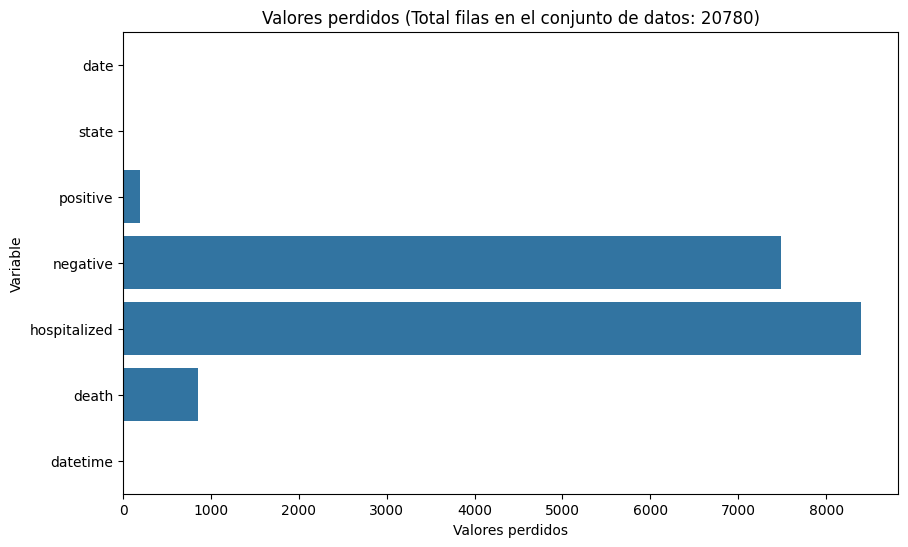

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

missing_data = df_subset.isna().sum()

missing_df = missing_data.reset_index()
missing_df.columns = ['Variable', 'Valores perdidos']

# Visualizar los valores nulos en un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Valores perdidos', y='Variable', data=missing_df)
plt.title(f'Valores perdidos (Total filas en el conjunto de datos: {len(df_subset.index)})')
plt.show()

Como se puede ver en la celda previa, existen una gran cantidad de datos perdidos entre nuestros datos, particularmente en la variable 'hospitalized' donde casi el 50% de los datos son perdidos. Ante esta situación antes de tomar decisiones sobre imputación, hay que evaluar que tipología de dato perdido presentan.

Los datos perdidos pueden categorizarse en tres grupos:
- MCAR (_Missing completely at random_): Será nuestra forma favorita de dato perdido, en este caso la probabilidad de que el dato se pierda es la misma para todos los casos de la base de datos, esto implica que las causas por las que se ha perdido el dato es ajena a la base de datos. Ejemplo de este tipo de datos perdidos es cuando se escoge una muestra aleatoria de una población, donde cada individuo tiene la misma probabilidad de ser incluido en la muestra, por lo que perder datos puede obedecer a mala suerte. A pesar de que es la forma ideal de perder datos, es poco realista.
- MAR (_Missing at random_): En este caso la probabilidad de que el dato se haya perdido es la misma pero solo en grupos definidos por los datos observables. Por ejemplo, *hipotéticamente*, en nuestro caso podría darse que en el estado de Kansas hay más datos perdidos que en el resto de estados, ya que tuvieron dificultades a la hora de registrar los datos por falta de personal. Si sabemos que este estado es el que genera más valores perdidos y podemos asumir MCAR *DENTRO* de la categoría de Kansas, los datos se consideran MAR. Es la opción más realista de dato perdido y sobre la que generalmente se trabaja, es importante recordar que los métodos de imputación asumen MCAR pero al no ser realista trabajamos con ellos en datos MAR asumiendo que puede haber sesgos.
- MNAR (_Missing not at random_): El peor caso de datos perdido, ya que los métodos de imputación no son recomendables bajo este tipo de dato ya que producen sesgos importantes. Este tipo de dato perdido refiere a que desconocemos de las causas de la probabilidad de que un dato sea perdido. Un ejemplo clásico de MNAR es en estudios de opinion pública, la gente que tiene opiniones menos fuertes sobre un tema tienden a responder menos a estas encuestas, por lo que se pierde su dato y no tenemos forma de "recuperarlo". La única solución a MNAR es realizar más estudios que analicen las causas de la pérdida o plantear escensarios _what if_.

En nuestro caso, podemos hacer una evualación sencilla agrupando los datos por estados, y así comprobar si la perdida de datos obedece a una cuestión de la metodología de recogida de datos en cada estado.

In [16]:
na_agrupado = df_subset.groupby('state')[["positive", "negative", "hospitalized", "death"]].apply(lambda x: x.isna().sum())
print(na_agrupado)

       positive  negative  hospitalized  death
state                                         
AK           11       367             3      0
AL            0         3            28      8
AR            0         0            26     16
AS           15        15           357      2
AZ            0         0             0      9
CA            0       320           369      8
CO            0         0            13      9
CT            7       373           198     19
DC            0       368           368     14
DE            0         0           367      2
FL            0        35            52     42
GA            0       369            21      9
GU            0         0           357      6
HI            3       165            20     28
IA            0         0           351     19
ID            0         0            21     15
IL            0       369           369     13
IN            8        12            71     16
KS            0         0            21      8
KY           

A primera vista no parece que haya un patrón evidente de que algún estado esté favoreciendo en mayor medida a la pérdida de datos, podemos ver que los valores más altos dentro de cada variable son más o menos similares, al igual que los valores más bajos presentan también valores similares. En este caso es posible que nos encontremos ante un caso de MNAR, lo cual es problemático a la hora de imputar valores perdidos. No obstante, como se trata de un ejercicio educativo, vamos a asumir que se trata de un caso MAR, pudiendo justificar de manera algo regulera que los estados con mayor población presentarán más datos perdidos al tener una carga mayor de trabajo. Si recordamos la estructura de la base de datos, cada dato perdido señala un día en el que la medición de esa variable se ha perdido.

La forma correcta de evaluar este tipo de patrones de datos perdidos es utilizando métodos estadísticos como ANOVA, pruebas t, etc. De nuevo, como se comentó previamente, se trata de un tema amplísimo, por lo que recomiendo investigar si os interesa ya que tiene un gran interés, pero también una alta complejidad. 

Otra opción que puede ser útil, _spoiler_ en este caso lo es, es comparar las distribuciones de los datos con sus estadísticos descriptivos o utilizando gráficos como los de caja y bigotes. Como la estructura del documento está siendo con intención de ir explicando diferentes conceptos no vamos a incluirlo en este punto, pero se verá más adelante a que obede esa pérdida de datos con los gráficos. En un análisis de datos exploratorio hay que tener en cuenta multiples visiones antes de tomar decisiones sobre que hacer con los datos.

#### Como imputar datos perdidos

Una vez hemos asumido que nuestros datos perdidos se ajustan a una clásificación MAR, se nos plantea la disyuntiva de que método usar para imputar los datos perdidos. Si se realiza una búsqueda en internet se pueden encontrar muchas formas que en lineas generales se han aceptado con bastante frecuencia y que probablemente a todo el mundo les suene:

- Sustituir los valores por la media
- Sustituir los valores por la moda
- Sustituir los valores por la mediana
- Sustituir los valores por valores predecidos mediante un modelo de regresión lineal con los valores existentes
- Eliminación por lista
- Eliminación por pares (calculo de medias y covarianzas en datos observados)

Todos estos métodos pueden ser útiles para sacarnos de un apuro o cuando los datos perdidos existentes son pocos.

**SIN EMBARGO**

Atendiendo a la literatura científica actual, ninguno de estos métodos es aceptable como forma de imputación de datos, ya que genera multitud de sesgos, generando pérdida de potencia estadística y problemas a la hora de realizar inferencias (entre otros problemas que no menciono aquí). La conclusión general de la mejor forma de imputar datos perdidos es utilizando los métodos de **Maxima Verosimilitud** (ML) e **Imputación Multiple**. Ambas opciones son asíntoticamente equivalentes para muestras grandes.

- ML es un método de estimación de parámetros, intenta encontrar los parámetros que hacen más probable la muestra observada. Es un método consistente bajo MAR y MNAR y es eficiente en tanto que la varianza del estimador es la menor alcanzable teóricamente por cualquier metodo de estimación (Olmos, 2022).
- Imputación múltiple crea $m > 1$ conjuntos de datos, desde una base de datos incompleta, genera múltiples versiones del conjunto de datos completas, reemplazando los valores perdidos por valores *plausibles*. Estos valores se extraen de una distribución modelada para cada dato perdido. Estos conjuntos de datos son iguales en los valores observados pero no en los valores perdidos. El segundo paso consiste en estimar los parámetros de interés de cada conjunto de datos imputado, utilizando el procedimiento análitico que hubieramos usado si los datos estuvieran completos (por ejemplo, una regresión lineal). Por último se agrupan los _m_ parámetros estimados en un único estimador, y se calcula su varianza. 

De nuevo cada uno de los métodos tiene una amplia base teórica detrás que puede ser de interés revisar. Todo esto es un pequeño resumen de los métodos aceptados actualmente en investigación. No obstante, lo más probable es que en un entorno laboral empresarial no haya que justificar nada y con reemplazar los valores por la media sea suficiente para poner a funcionar un modelo. Sin embargo, siempre es relevante tener a mano la información más actualizada y específica. 

De todos estos casos hay amplia documentación y ejemplos en páginas como Kaggle, la literatura que se ha proporcionado previamente o si me preguntáis seguro que tengo algo por ahí (Sobretodo controlo de hacerlo en R, en Python estoy en ello).

A continuación se muestra el código de una imputación múltiple para tener un ejemplo de como sería, de nuevo, si se quiere hacer recomiendo investigar antes sobre ello.

Después se muestran imputaciones con medidas de tendencia central (media, mediana, etc.) que dependen de analizar antes los valores atípicos.

In [41]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

df_complete = df_subset[["date", "state", "datetime"]]
df_missing = df_subset[["positive", "negative", "hospitalized", "death"]]

imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending', max_iter=30, random_state=0)

imputed_data = imputer.fit_transform(df_missing)

df_imputed = pd.DataFrame(imputed_data, columns=df_missing.columns)

df_final = pd.concat([df_complete, df_imputed], axis=1)

Una vez se ha visto el ejemplo de imputación múltiple, pasamos a trabajar con los métodos más habituales de imputación.

Un comentario previo, la decisión de que hacer antes, limpiar los datos o analizar los valores atípicos depende del investigador y del tipo de datos con los que estén trabajando, frente a esta cuestión no hay una respuesta definitiva. En el caso de los métodos tradicionales, es relevante realizar previamente el análisis de valores atípicos ya que hay métodos que resultan más adecuados en función de si existen muchos valores extremos o no, y del grado de asimetría de la distribución. Se aplica en todo caso en sustitución por valores de tendencia central como la media o la mediana.

### Outliers o casos atípicos

Existen diversas formas de analizar valora atípicos y de categorizarlos como atípicos o no. En primer lugar en todo análisis es relevante extraer los valores descriptivos para hacernos una idea de la distribución muestral, en particular la asimetría (acumulación de datos en alguno de los extremos de la distribución) y la curtosis (aplanamiento o apuntamiento de la distribución, nos indica si hay mayor o menor varianza en la muestra).

Para determinar si la muestra se ajusta a unos valores aceptables existen diferentes métodos estadísticos. Estos métodos dependen además de los típos de estadísticos que estamos calculando, en lineas generales, cuando trabjamos en análisis estadístico esperamos que nuestra muestra se ajuste a una distribución normal, ya que es la más común en distribuciones de datos y muchos análisis se basan en ella. La razón por la que la distribución 'normal' es tan común se debe a un concepto matemático conocido como el **teorema central del límite** el cual indica a grandes rasgos que en, condiciones muy generales, la suma suficientemente grande de variables aleatorias e independientes, con media y varianza finita, tiende a converger en la distribución normal.

Para evaluar la adecuación de una distribución a la curva normal, lo que se conoce también como cumplimiento del supuesto de normalidad existen multitud de métodos. La prueba de Kolmogorov-Smirnov o el test Mardia para confirmar normalidad multivariante. La forma más sencilla por otra parte es utilizar valores límites para la asimetría y la curtosis obtenidos en un análisis descriptivo. Byrne (2013) establece los límites para asimetría entre -2 y 2 y los límites para la curtosis entre -7 y 7. 

También pueden utilizarse de forma visual histogramas para ver la forma de la distribución, no obstante es mejor utilizar métodos que requieran menos interpretación subjetiva.

Con respecto a los valores atípicos como tal, hay diferentes aproximaciones. En general se considera dato atípico aquel que presenta un valor superior al valor del cuartil 3 (Q3) + 1.5 por el valor del rango intercuartil (IQR), y por el otro lado un valor inferior al valor del cuartil 1 (Q1) + 1.5 por el valor del rango intercuartil (IQR).

- Outliers de valores altos: $Q3 + (1.5 · IQR)$
- Outliers de valores bajos: $Q1 - (1.5 · IQR)$

El rango intercuartil es una medida de dispersión que que se define como la diferencia entre el percentil 75 y el 25 de los datos.

Otra forma de detectar la existencia de valores atípicos es utilizar las puntuaciones Z. La puntuación Z es una puntuación estandarizada que permite convertir los valores de una variable en una puntuación facilmente interpretable. Las puntuaciones Z se distribuyen en una función normal con media = 0 y desviación típica = 1, cada puntuación indica cuantas desviaciones típicas se aleja la puntuación de la media. La puntuación z puede calcularse facilmente con la función _zscores_ de la biblioteca _stats_. No obstante, su cálculo a mano no es especialmente complejo, la fórmula para calcular una puntuación z es:

- $ Z = {(X - \mu) \over \sigma} $

Donde X es la puntuación en su escala original, $ \mu $ es la media poblacional y $\sigma$ la desviación típica poblacional.

Utilizando este método las puntuaciones atípicas se consideran aquellas con un valor Z absoluto de 3.

Si queremos una forma sencilla y visual para interpretar si tenemos muchos valores atípicos en la distribución, podemos utilizar un diagrama *box-plot* o de caja y bigotes. Este tipo de diagramas tiene varios elementos, un cuadrado (la caja) dividido por una linea, representando los valores entre el 25% y el 75% de la distribución (lo que antes hemos definido como rango intercuartil), o dicho de otra forma los cuartiles 2 y 3. La línea que divide la caja es la mediana, y la líneas externas a la caja definen el cuartil 1 y el cuartil 4. Como puntos alejados del diagrama principal aparecen los valores atípicos u outliers.

Este diagrama se puede hacer de forma muy fácil utilzando la biblioteca seaborn.

Una opción para mostrar los datos es dividirlos en función del estado, ya que inicialmente se planteo analizar diferencias por estado entre las variables, a continuación se muestra un ejemplo con 'death'. Como se podrá ver, intentar mostrar todos los estados a la vez es un horror visual ya que hay 56 categorías posibles.

Otras opciones son mostrar cada estado por separado con su gráfico o mostrar únicamente las variables de interés sin tener en cuenta ninguna variable de agrupación.

Elijase la opción que se elija, el mayor problema una vez detectados los datos atípicos es qué hacer con ellos. Esta respuesta de nuevo dependerá de los datos, y si estos valores atípicos tienen sentido. En algunos casos nos encontraremos con que un valor extremo no tiene sentido en la distribución, y puede haberse debido a un error humano al apuntar los datos o alguna razón similar. En estos casos podemos intentar recuperar el dato si tenemos alguna forma de descubrir cual es el error (por ejemplo se ha añadido un 0 a un número) o si simplemente se da por perdido. En otros casos los valores atípicos, aún siendo atípicos no quiere decir que no sean reales ni que tengan sentido. Por ejemplo, en el caso que estamos trabajando, valores extremos en una variable como 'muertes' puede deberse a que la medición en ese momento coincidía con una ola especialmente virulenta del covid, dando valores mucho más altos de los esperados, pero que siguen siendo reales e importantes de mantener en la base de datos.

De nuevo, como viene siendo la tónica en estas reflexiones, prima el sentido común y los conocimientos que tengamos sobre los datos a la hora de tomar decisiones.

#### Representación visual

Vamos a representar estas distribuciones con una combinación de gráficos de caja y bigotes y unos histogramas. Como se podrá ver, si los agrupamos por estados, que es la forma en la que se ha decidido trabajar en este notebook pero no es la única opción, nos queda un desastre visual prácticamente ilegible que resolveremos más adelante.
Se presenta también como serían los gráficos agrupando por un solo estado y sin agrupación para ver como se vería en esos casos.

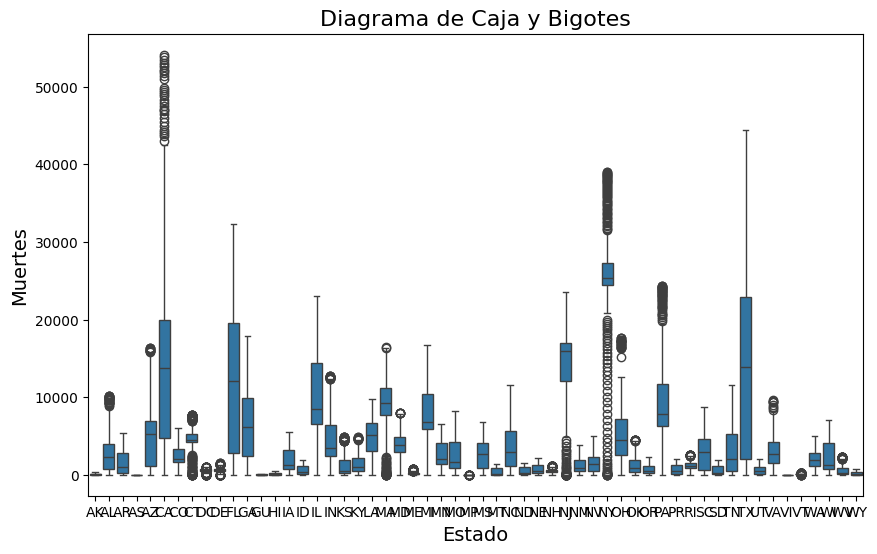

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) # Definición del tamaño del gráfico
box_plot = sns.boxplot(x='state', y='death', data=df_subset)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Muertes', fontsize=14)

plt.show()

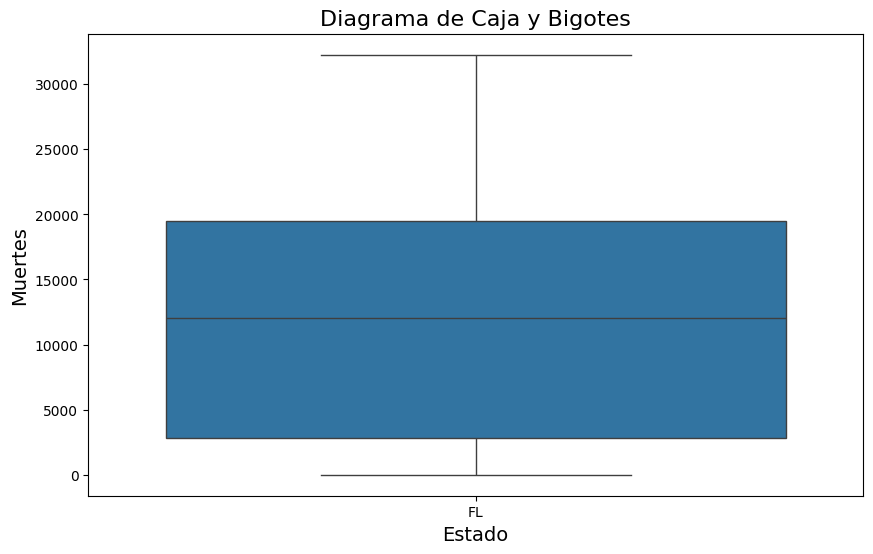

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df_FL = df_subset[df_subset["state"] == 'FL']

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='death', data=df_FL)


plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Muertes', fontsize=14)

plt.show()

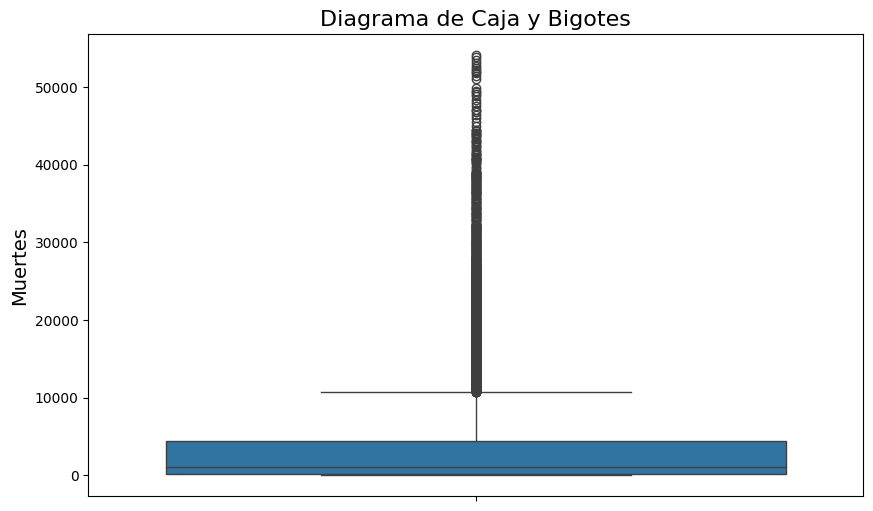

In [21]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(df_subset["death"])


plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.ylabel('Muertes', fontsize=14)

plt.show()

En este último gráfico de caja y bigotes para la varibale de muertes vemos que según la construcción del gráfico hay una cantidad de outliers apabullante, obviamente no podemos tomar decisiones de eliminar todos estos datos porque es evidente que no obedece a un error en la toma de datos. En este caso se debe a la variabilidad del covid, las fechas en las que se toman las medidas, las poblaciones de los diferentes estados, etc.

A continuación vamos a ver los histogramas de las variables que hemos seleccionado para el estudio para ir viendo su distribución.

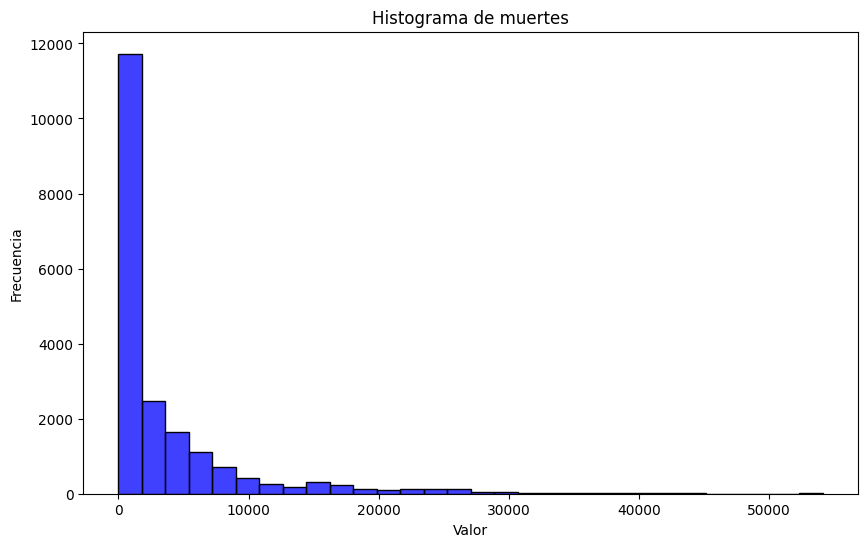

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['death'], kde=False, bins=30, color='blue')

# Añadir títulos y etiquetas
plt.title('Histograma de muertes')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

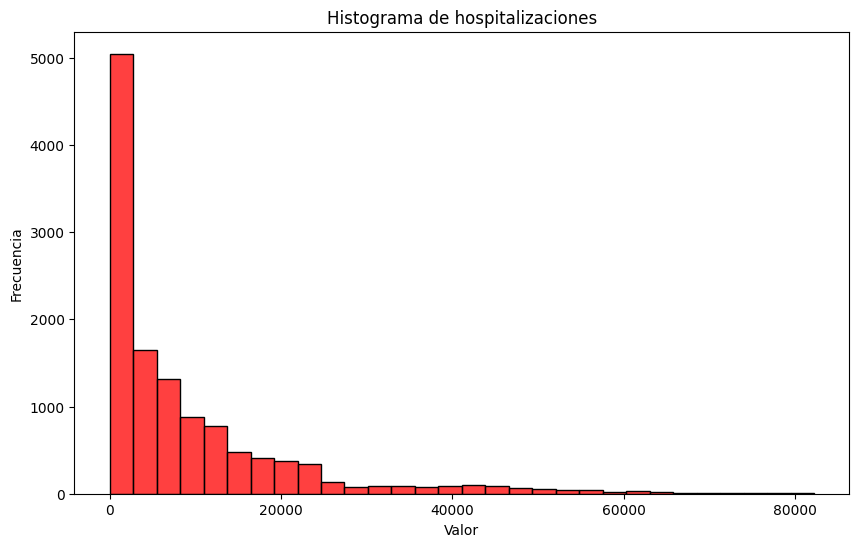

In [43]:
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['hospitalized'], kde=False, bins=30, color='red')

# Añadir títulos y etiquetas
plt.title('Histograma de hospitalizaciones')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

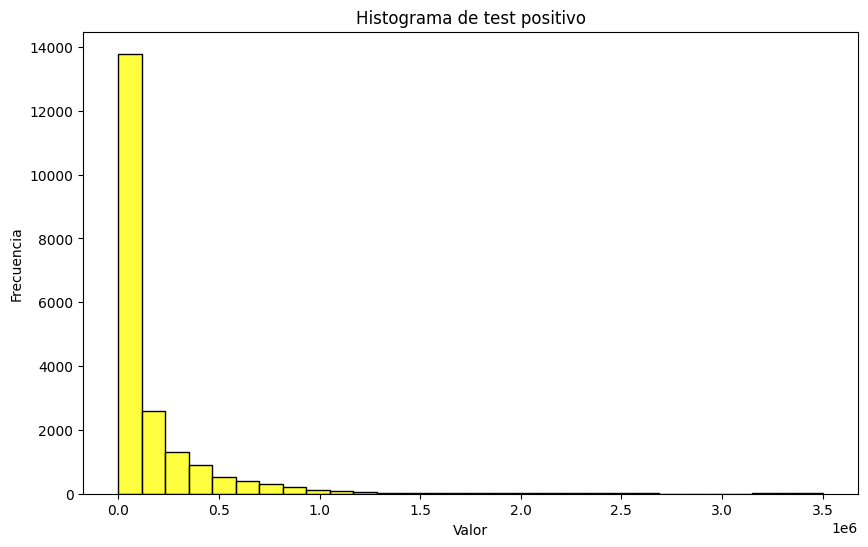

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['positive'], kde=False, bins=30, color='yellow')

# Añadir títulos y etiquetas
plt.title('Histograma de test positivo')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

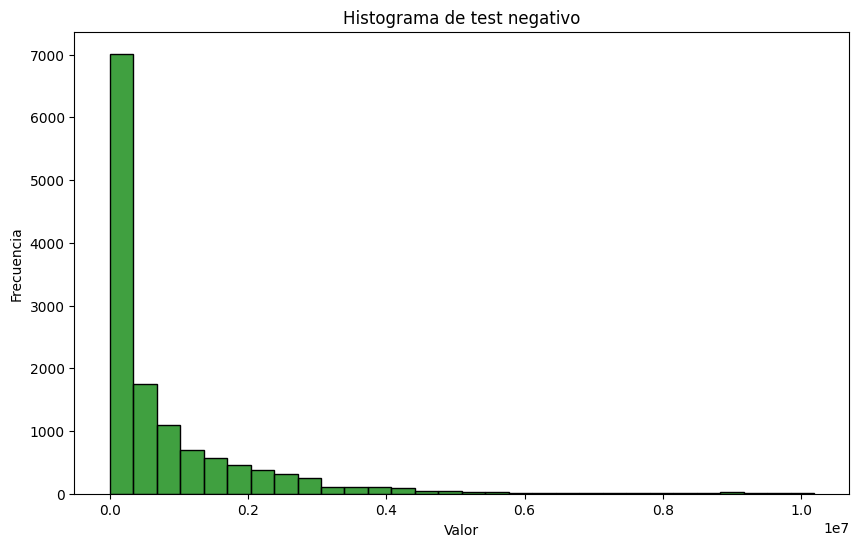

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['negative'], kde=False, bins=30, color='green')

# Añadir títulos y etiquetas
plt.title('Histograma de test negativo')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

Parece evidente al ver los gráficos que no se están ajustando a una distribución normal. Todos los gráficos presentan una asimetría positiva bastante grande, con una gran acumulación de los datos en los valores de 0. Teniendo en cuenta como vimos antes el gran número de datos perdidos que presentan algunas de las variables tiene sentido que la función sea tan asimétrica, lo cual nos sirve muy bien de ejemplo visual para entender el problema de los datos perdidos y de como modifican una distribución.

Se pueden utilizar también otros modelos de gráficos, para ver la forma de la distribución pueden utilizarse gráficos de densidad y para ver valores atípicos también puede utilizarse gráficos de dispersión (scatterplot), donde los valores atípicos aparecerán alejados del resto de puntuaciones.

Para facilitar la visualización de datos y reducir la dimensionalidad de la gráfica, podemos trabajar en lugar de con la totalidad del conjunto de datos con los estados con mayor población. Existen otras formas de reducción de la dimensionalidad, pero en este caso lo único que queremos es trabajar con un conjunto de datos más pequeño y manejable, además de que teóricamente parece razonable trabajar con aquellos grupos poblacionales más númerosos. Además, en el caso de EEUU tenemos que los estados con mayor población son además estados con bastantes diferencias entre sí, tanto a nivel geográfico como a nivel político (por ejemplo Texas y California) con lo que se puede entender que son una buena muestra para poder extrapolar al conjunto de la población estadounidense.

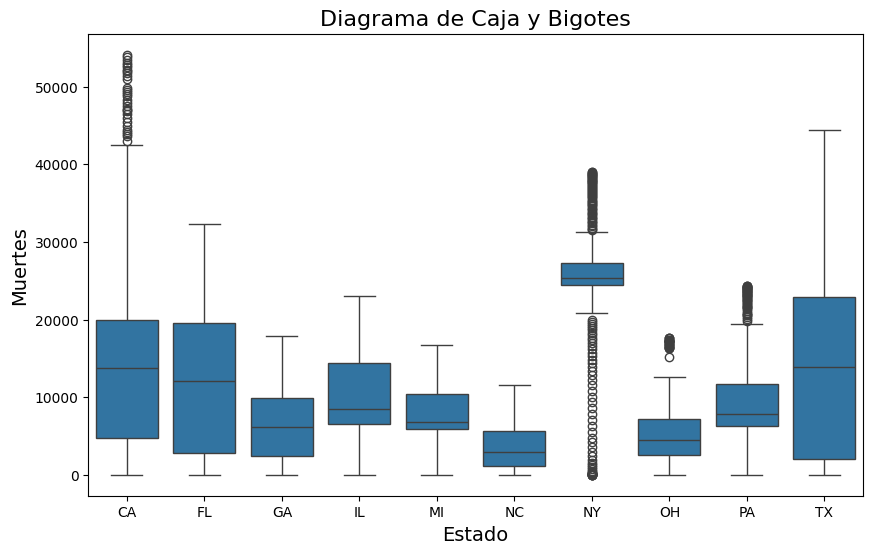

In [47]:
df_top10 = df_subset[df_subset["state"].isin(['CA','TX', 'FL', 'NY', 'PA', 'IL', 'OH', 'GA', 'NC', 'MI'])]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='death', data=df_top10)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Muertes', fontsize=14)

plt.show()



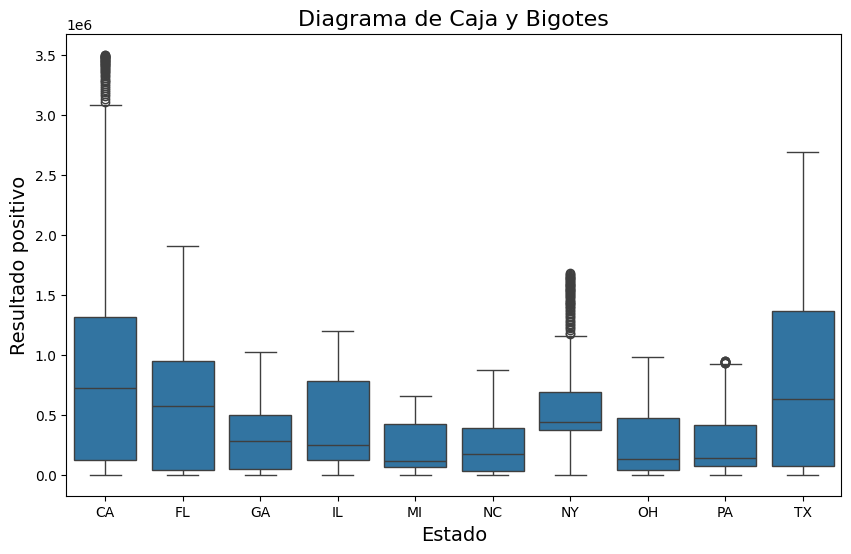

In [23]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='positive', data=df_top10)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Resultado positivo', fontsize=14)

plt.show()

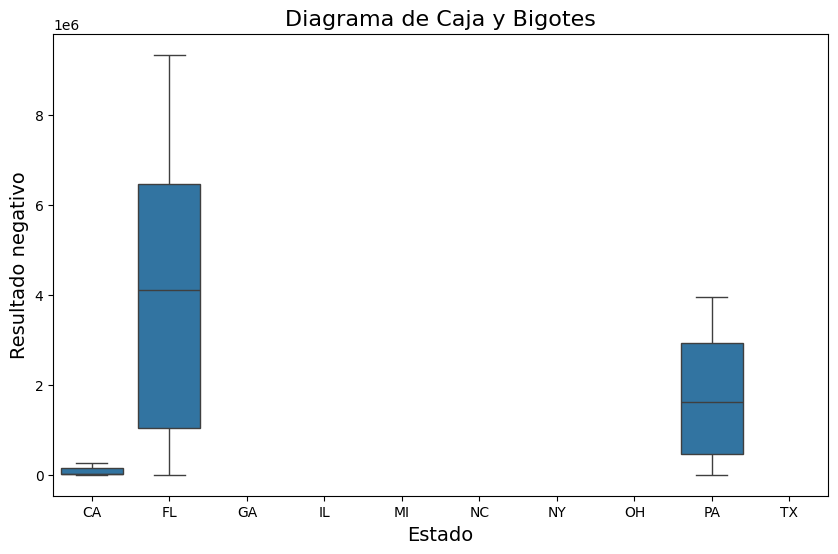

In [10]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='negative', data=df_top10)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Resultado negativo', fontsize=14)

plt.show()

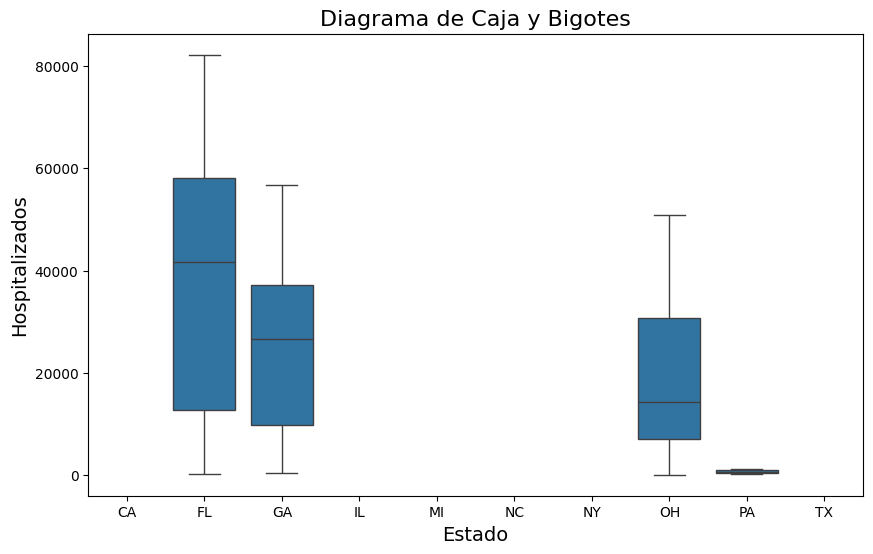

In [24]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='hospitalized', data=df_top10)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Hospitalizados', fontsize=14)

plt.show()

La representación visual por caja y bigotes nos acaba de solucionar algo que ya comentamos previamente respecto a los datos perdidos. Para nuestras variables de hospitalizados y resultado negativo nos encontramos con una perdida de datos completa en algunos de los estados que se han incluido. El problema principal de este resultado es que no tenemos forma de determinar la razón por la que esos datos se han perdido (quizá en su documentación lo especifiquen pero no me ha dado tiempo a revisarlo a fondo) lo que nos obliga a asumir un patrón de datos perdidos MNAR, y, teniendo en cuenta que la perdida de datos es total, no es asumible imputarlos, con lo que tendremos que prescindir de ellos para nuestros análisis estadísticos.

Por no quedarnos sin hacer pruebas, y aunque no sea la mejor metodología, podemos hacer las pruebas para hospitalizados con los estados de Florida, Georgia y Ohio, y con test negativos con los estados de Florida y Pensylvania.

¿Que hacer entonces con los outliers? En este caso mi recomendación sería no modificar la base de datos por las razones que se han comentado antes, es perfectamente factible que no sean datos atípicos y que simplemente obedezcan a patrones que no se han contemplado en la recogida de datos o a la hora de enfocar la investigación, no obstante si se quisieran eliminar, se puede construir un breve código que convierta las puntuaciones a valores z (por ejemplo) y eliminar aquellos casos que presenten valores Z por encima del valor absoluto 3.

Con los datos perdidos nos encontramos una situación similar, el hecho de que haya datos perdidos por completo en diferentes estados dificulta la toma de decisiones. Lo que está claro es que no podemos imputar datos que estén completamente perdidos y querer trabajar con ello, es un sinsentido. En ese caso tendremos que tomar la decisión de cambiar el foco del análisis. Para este ejemplo una opción con la que podemos trabajar, que de nuevo no es recomendable, ya que las hipótesis de investigación se plantean antes de empezar el análisis, es modificar nuestras hipótesis y trabajar con aquellos estados que tengan datos que permitan hacer comparaciones. Se elige esta forma ya que es más descriptiva para un ejercicio de formación.

Por tanto haremos:
- Evolución temporal de las diferentes variables por estados
- Relación entre muertes y tests positivos
- Diferencias entre FL y PA en test negativos.
- Diferencias entre FL, GA y OH en hospitalizaciones.

Para imputar los datos vamos a utilizar el método de imputación múltiple que vimos antes ya que es el más recomendado, si se quisiera utilizar un método más clásico podemos reemplazar los valores por la media de cada variable, atendiendo a los valores atípicos de las distribuciones.

### Descriptivos y frecuencias

Antes de empezar con la imputación y los análisis, queda comentar como extraer los datos descriptivos de las variables de la base de datos. Los descriptivos hacen referencia a las medidas que no permiten hacernos una idea de como es la distribución de los datos sin utilizar gráficos, extrayendo numéricamente los valores de las medidas de tendencia central (media, mediana) y dispersión (desviación típica, cuartiles, máximo y mínimo). Este formato nos permite también analizar de otra forma los valores perdidos y los valores atípicos, por ejemplo variables que presenten valores mínimos o máximos muy distantes de la media o de lo esperado por el/la investigador/a puede indicar que hay algún valor atípico. Del mismo modo y como veremos a continuación, es fácil ver replicados los resultados que hemos visto gráficamente de datos perdidos en ciertos estados, viendo que los valores de media son NaN. Por conveniencia estos valores suelen redondearse a 2 decimales para facilitar su lectura (recomendaciones APA 7th).

Este análisis solo puede realizarse con variables numéricas. Para variables categóricas se realizan análisis de frecuencias, que a grandes rasgos indican el porcentaje de pertenencia a las diferentes categorías de una variable, por ejemplo 'hombre' y 'mujer'. Es útil para determinar si nuestro conjunto de datos tiene sesgos de sobre o infra representación de algunas de las categorías.

In [50]:
round(df_top10.groupby('state')[['positive', 'negative', 'hospitalized', 'death']].describe(), 2)

positive                                                                 \
         count        mean         std   min        25%       50%         75%   
state                                                                           
CA       369.0  1027372.52  1110251.85  53.0  119807.00  722283.0  1311625.00   
FL       404.0   610241.20   597437.17   0.0   38306.75  571917.5   951154.75   
GA       369.0   334685.94   313381.42   2.0   49847.00  279354.0   499371.00   
IL       369.0   421473.41   401274.18   4.0  124759.00  247299.0   779975.00   
MI       372.0   222667.40   218523.33  14.0   64030.50  114855.0   421845.00   
NC       369.0   259209.66   267102.85   1.0   31966.00  174254.0   388552.00   
NY       371.0   584592.02   426828.16   0.0  373562.50  437107.0   690744.50   
OH       368.0   280253.66   324434.38   0.0   37639.00  129114.5   469330.00   
PA       367.0   275401.54   295081.20   2.0   75355.50  138625.0   415799.00   
TX       369.0   843475.48   840817.25   0.0   69920.00  630829.0  1364933.00   

                 negative              ... hospitalized           death  \
             max    count        mean  ...          75%      max  count   
state                                  ...                                
CA     3501394.0     49.0    70570.04  ...          NaN      NaN  361.0   
FL     1909209.0    369.0  4024002.70  ...     58024.25  82237.0  362.0   
GA     1023487.0      0.0         NaN  ...     37093.00  56797.0  360.0   
IL     1198335.0      0.0         NaN  ...          NaN      NaN  356.0   
MI      656072.0      0.0         NaN  ...          NaN      NaN  363.0   
NC      872176.0      0.0         NaN  ...          NaN      NaN  357.0   
NY     1681169.0      0.0         NaN  ...          NaN      NaN  358.0   
OH      978471.0      0.0         NaN  ...     30803.00  50881.0  353.0   
PA      948643.0    362.0  1726797.65  ...       928.00   1145.0  355.0   
TX     2686818.0      0.0         NaN  ...          NaN      NaN  356.0   

                                                                      
           mean       std  min       25%      50%       75%      max  
state                                                                 
CA     15881.13  14011.90  4.0   4776.00  13758.0  19935.00  54124.0  
FL     12353.57   9717.78  2.0   2860.50  12045.0  19502.50  32266.0  
GA      6525.56   4917.90  1.0   2363.50   6099.0   9856.50  17906.0  
IL     10115.78   6556.85  1.0   6484.25   8483.0  14441.25  23014.0  
MI      7967.11   4375.97  0.0   5946.50   6810.0  10371.50  16658.0  
NC      3773.51   3263.35  0.0   1104.00   2990.0   5605.00  11502.0  
NY     24733.15   8387.23  3.0  24503.00  25373.5  27288.25  39029.0  
OH      5409.65   4318.78  1.0   2597.00   4411.0   7187.00  17656.0  
PA      9532.79   6552.85  1.0   6229.00   7837.0  11652.00  24349.0  
TX     14764.07  13182.73  1.0   1971.25  13925.0  22876.25  44451.0  

[10 rows x 32 columns]

Si realizamos la imputación de datos y volvemos a extraer los descriptivos veremos como algunos de los valores se ven modificados (sobretodo los que tenían todos los valores perdidos, pero esos no se deberán usar).

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

df_complete = df_top10[["date", "state", "datetime"]]
df_missing = df_top10[["positive", "negative", "hospitalized", "death"]]

imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending', max_iter=30, random_state=0)

imputed_data = imputer.fit_transform(df_missing)

df_imputed = pd.DataFrame(imputed_data, columns=df_missing.columns)

df_final = pd.concat([df_complete, df_imputed], axis=1)

round(df_final.groupby('state')[['positive', 'negative', 'hospitalized', 'death']].describe(), 2)

positive                                                             \
         count       mean        std   min       25%       50%        75%   
state                                                                       
CA        67.0  487520.63  566182.98   0.0  56108.50  241705.0  764816.50   
FL        67.0  507276.73  695573.11   0.0  75054.00  321181.0  636851.00   
GA        67.0  494228.85  581519.40   0.0  49588.50  254281.0  747759.50   
IL        67.0  476448.12  615580.68   0.0  77017.00  312977.0  627560.50   
MI        67.0  487366.84  665998.45   0.0  79816.00  288978.0  616594.00   
NC        67.0  498026.82  686482.27   0.0  74072.50  303058.0  628634.50   
NY        66.0  485058.24  566390.16   0.0  49791.00  259270.5  762687.50   
OH        66.0  487528.62  637864.93  17.0  81910.75  324699.5  607000.25   
PA        66.0  488764.23  573342.12   3.0  54457.25  244464.0  737516.25   
TX        66.0  487860.75  560186.11  13.0  59653.25  258835.0  756467.25   

                 negative              ... hospitalized            death  \
             max    count        mean  ...          75%        max count   
state                                  ...                                 
CA     2553127.0     67.0  3125832.49  ...     42467.29  118982.84  67.0   
FL     3497578.0     67.0  3102317.92  ...     40491.10  159557.85  67.0   
GA     2574194.0     67.0  3149109.05  ...     42679.83  119989.98  67.0   
IL     3371556.0     67.0  2927442.08  ...     40496.44  149151.09  67.0   
MI     3470877.0     67.0  3003668.15  ...     39884.12  157154.18  67.0   
NC     3488467.0     67.0  3056348.73  ...     40286.22  158646.88  67.0   
NY     2588101.0     66.0  3124709.20  ...     42695.35  120836.98  66.0   
OH     3435186.0     66.0  2982865.87  ...     39901.53  153742.96  66.0   
PA     2563949.0     66.0  3121409.71  ...     42209.09  119493.43  66.0   
TX     2583617.0     66.0  3135753.59  ...     42492.75  120594.52  66.0   

                                                                    
           mean       std  min      25%     50%       75%      max  
state                                                               
CA      9024.90   8966.01  4.0  2569.50  5823.0  12698.00  40378.0  
FL     12929.56  11451.17  1.0  5139.95  8479.0  19173.00  53866.0  
GA      9191.38   9215.93  3.0  2591.00  5894.0  13290.50  40814.0  
IL     12477.04  10570.70  4.0  4663.00  8648.0  18687.50  45456.0  
MI     12670.94  10957.92  1.0  5358.19  8308.0  18340.50  51821.0  
NC     12809.79  11257.84  0.0  5292.74  8123.0  18787.50  53048.0  
NY      8973.63   8996.67  0.0  2226.75  5949.0  13552.25  41343.0  
OH     12664.81  10550.37  7.0  5426.25  9101.0  18723.25  48825.0  
PA      9122.43   9075.46  6.0  2591.25  5687.5  13034.50  40593.0  
TX      9079.87   8896.04  5.0  2580.25  6136.5  13462.00  41213.0  

[10 rows x 32 columns]

## Análisis de datos
### Evolución temporal

Para observar la evolución temporal de las muertes podemos utilizar de nuevo seaborn, graficando un gráfico de lineas que en el eje y nos muestre las fechas y en el eje x el número de fallecidos. Podemos añadir diversas lineas en tonos distintos para distinguir entre estados.

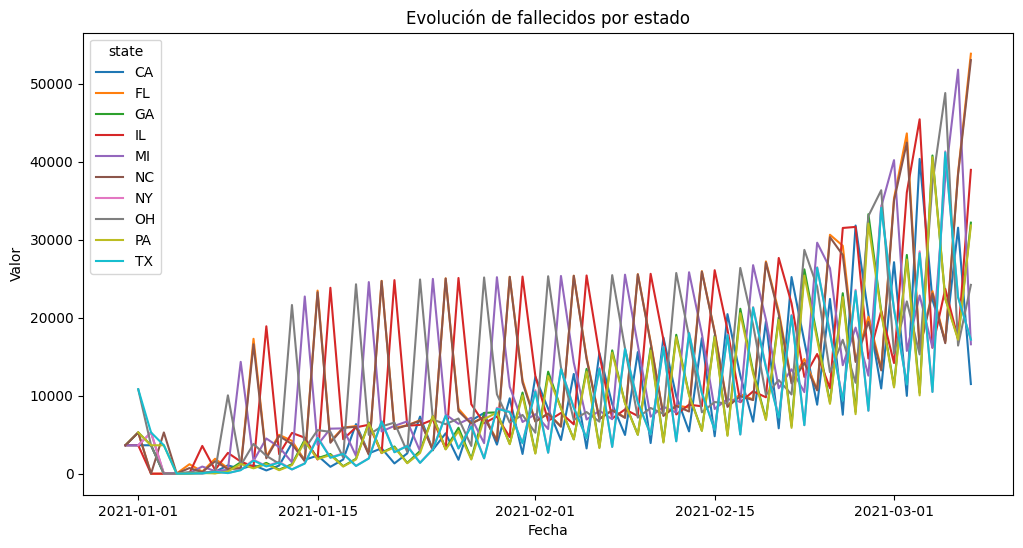

In [53]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_final, x='datetime', y='death', hue='state', palette='tab10')

plt.title('Evolución de fallecidos por estado')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.show()

Al haber tantos estados nos queda un gráfico muy poco visual, para poder ver de mejor forma como queda un gráfico de lineas temporales podemos seleccionar dos estados para ver mejor la distribución.

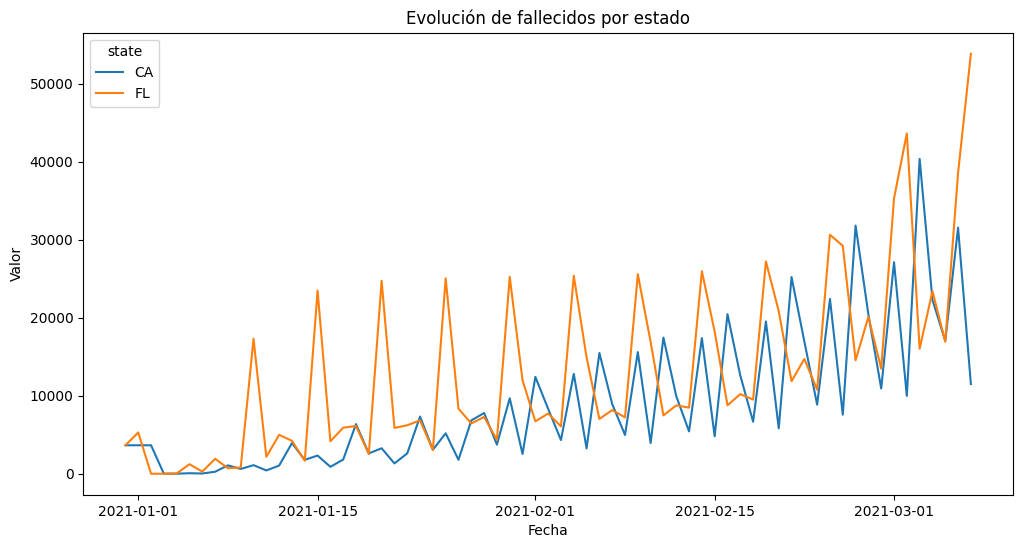

In [54]:
df_top2 = df_final[df_final['state'].isin(['CA', 'FL'])]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top2, x='datetime', y='death', hue='state', palette='tab10')

plt.title('Evolución de fallecidos por estado')
plt.xlabel('Fecha')
plt.ylabel('Valor')

plt.show()

En este gráfico más visual podemos ver que la cifra de fallecidos es bastante inconsistente, con muchos picos de subida y bajada, pero en general con una tendencia a la subida si comparamos las primeras fechas ocn las últimas. En el caso de California vemos que teniendo una población similar a Florida sus valores se encuentran de forma general por debajo de los de Florida, por lo que podría ser interesante determinar si esta diferencia es realmente significativa y, de serlo, investigar que razones puede haber para ello.

### Relación entre muertes y casos positivos

La forma más común de establecer la relación entre una variable y otra es utilizar el coeficiente de correlación de Pearson. Esta medida de dependencia lineal nos indica el grado de relación entre dos variables cuantitativas y continuas (importante cumplir ambas). El coeficiente de correlación de Pearson toma valores entre -1 (correlación negativa perfecta) y 1 (correlación positiva perfecta). Las correlaciones positivas nos indican que si el valor de una variable aumenta el otro también y en el caso de las negativas a la inversa.

Para considerar una correlación como relevante debe tener significación estadística, no nos vale con que el valor sea alto. Es más, es érronea pensar que el valor del coeficiente de correlación sea indicativo de nada por si solo. Algunas publicaciones hablan de rangos para determinar si una relación es mejor o peor en función de sus valores, pero lo que nos indica si el valor de la correlación es relevante, aparte de su significación estadística, es lo que hay en la literatura previa. Una correlación de 0.2 con un p valor menor a 0.05, que indica que se rechaza la hipótesis nula de que las variables son independientes y por tanto es estadísticamente significativo (el tema de los p valores se debe ver aparate por su extensión), puede ser un hallázgo muy importante si nunca se ha encontrado un valor tan alto en estudios previos.

Otra cosa **MUY MUY IMPORTANTE** respecto a la correlación es que **CORRELACIÓN NO IMPLICA CAUSALIDAD**.

No podemos asumir que porque dos variables presenten una correlación muy alta entre ellas presenten algún tipo de relación causa-efecto porque puede ser que no tengan una relación directa, lo que se conoce como una correlación espúrea. 